# 소비자 데이터 기반 소비 예측 경진대회

1. train.csv : 학습 데이터
- id : 샘플 아이디
- Year_Birth : 고객 생년월일
- Education : 고객 학력
- Marital_status : 고객 결혼 상태
- Income : 고객 연간 가구 소득
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수
- NumDealsPurchases : 할인된 구매 횟수
- NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases : 카탈로그를 사용한 구매 수 
- NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량


2. test.csv : 테스트 데이터

3. sample_submission.csv : 제출 양식
- id : 샘플 아이디
- target : 고객의 제품 총 소비량

4. 평가지표 NMAE

```python
import numpy as np

def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score
```

## Import

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

import warnings
warnings.filterwarnings('ignore')

import os
import itertools
import multiprocessing

In [2]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, LinearSVR

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from glob import glob
from scipy.stats import chi2_contingency, kstest
from statsmodels.formula.api import ols

In [ ]:
train = pd.read_csv('C:/data/train.csv')
test = pd.read_csv('C:/data/test.csv')
sample_submission = pd.read_csv('C:/data/sample_submission.csv')

In [ ]:
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

## 데이터 구조

In [ ]:
train['Dt_Customer'] = pd.to_datetime(train['Dt_Customer'])
test['Year_Birth'] = pd.to_datetime(test['Year_Birth'], format='%Y').dt.year

In [ ]:
train_cut = pd.cut(train['target'], bins=10, labels=['target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_8', 'target_9', 'target_10'])
train_cut = pd.DataFrame(train_cut)

In [ ]:
train_datetime = [['Year_Birth', 'Dt_Customer']]
train_cat = train[['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response']]
train_cat = pd.concat([train_cat, train_cut], axis=1)

train_num = train.drop(['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response', 'target'], axis=1)
train_num = pd.concat([train_num, train_cut], axis=1)

test_datetime = [['Year_Birth', 'Dt_Customer']]
test_cat = test[['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response']]
test_num = test.drop(['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response'], axis=1)

## 파생변수

In [ ]:
train['Marital_Status'] = train['Marital_Status'].replace(['Together', 'Married' , 'Absurd'], 'not alone')
test['Marital_Status'] = test['Marital_Status'].replace(['Together', 'Married' , 'Absurd'], 'not alone')

train['Marital_Status'] = train['Marital_Status'].replace(['Single', 'Widow', 'Divorced', 'YOLO', 'Alone'], 'alone')
test['Marital_Status'] = test['Marital_Status'].replace(['Single', 'Widow', 'Divorced', 'YOLO', 'Alone'], 'alone')

train['Marital_Status'] = train['Marital_Status'].map({'not alone' : 1, 'alone' : 0})
test['Marital_Status'] = test['Marital_Status'].map({'not alone' : 1, 'alone' : 0})

In [18]:
train.corr()['target']

Year_Birth            -0.136035
Marital_Status        -0.032529
Income                 0.784084
Kidhome               -0.538365
Teenhome              -0.109214
Recency                0.050873
NumDealsPurchases     -0.072802
NumWebPurchases        0.546082
NumCatalogPurchases    0.798065
NumStorePurchases      0.677785
NumWebVisitsMonth     -0.488252
AcceptedCmp3           0.040736
AcceptedCmp4           0.256784
AcceptedCmp5           0.458208
AcceptedCmp1           0.361102
AcceptedCmp2           0.129995
Complain              -0.058704
Response               0.242760
target                 1.000000
Name: target, dtype: float64

## Scailing

In [51]:
target = train['target']

In [52]:
train_cat = train_cat.drop(['target'], axis=1)
train_num = train_num.drop(['target'], axis=1)

In [53]:
train_Year_Birth = train_num[['Year_Birth']]
train_Dt_Customer = train_num[['Dt_Customer']]

test_Year_Birth = test_num[['Year_Birth']]
test_Dt_Customer = test_num[['Dt_Customer']]

In [54]:
train_num = train_num.drop(['Year_Birth', 'Dt_Customer'], axis=1)
test_num = test_num.drop(['Year_Birth', 'Dt_Customer'], axis=1)

In [23]:
scaler = MinMaxScaler()
train_num[:] = scaler.fit_transform(train_num)
test_num[:] = scaler.fit_transform(test_num[:])

In [24]:
label = LabelEncoder()

for col in train_cat.columns:
    train_cat[col] = label.fit_transform(train_cat[col])

In [25]:
for col in test_cat.columns:
    test_cat[col] = label.fit_transform(test_cat[col])

In [55]:
train = pd.concat([train_cat, train_num, target], axis=1)
train.head()

,Education,Marital_Status,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,target
0,Master,Together,0,0,0,0,0,0,0,46014.0,1,1,21,10,7,1,8,7,541
1,Graduation,Single,0,0,1,0,0,0,0,76624.0,0,1,68,1,5,10,7,1,899
2,Graduation,Married,0,0,0,0,0,0,0,75903.0,0,1,50,2,6,6,9,3,901
3,Basic,Married,0,0,0,0,0,0,0,18393.0,1,0,2,2,3,0,3,8,50
4,PhD,Together,1,0,0,0,0,0,0,64014.0,2,1,56,7,8,2,5,7,444


In [56]:
test = pd.concat([test_cat, test_num], axis=1)
test.head()

,Education,Marital_Status,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,Graduation,Single,0,0,0,0,0,0,0,57537.0,1,0,83,4,4,3,8,4
1,Graduation,Together,0,0,0,0,0,1,0,65748.0,0,1,58,2,2,4,10,1
2,Graduation,Married,0,0,0,0,0,0,0,55434.0,1,0,21,3,5,3,13,4
3,Graduation,Married,0,0,0,1,0,0,0,67716.0,0,1,8,4,7,4,13,5
4,Graduation,Together,1,0,0,0,0,0,0,85606.0,0,1,89,2,6,7,9,3


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            1108 non-null   int32  
 1   Marital_Status       1108 non-null   int32  
 2   AcceptedCmp1         1108 non-null   int64  
 3   AcceptedCmp2         1108 non-null   int64  
 4   AcceptedCmp3         1108 non-null   int64  
 5   AcceptedCmp4         1108 non-null   int64  
 6   AcceptedCmp5         1108 non-null   int64  
 7   Complain             1108 non-null   int64  
 8   Response             1108 non-null   int64  
 9   Income               1108 non-null   float64
 10  Kidhome              1108 non-null   float64
 11  Teenhome             1108 non-null   float64
 12  Recency              1108 non-null   float64
 13  NumDealsPurchases    1108 non-null   float64
 14  NumWebPurchases      1108 non-null   float64
 15  NumCatalogPurchases  1108 non-null   f

## Modeling

In [33]:
from pycaret.regression import *

In [57]:
regression = setup(data=train, target='target', session_id=25)

,Description,Value
0,session_id,25
1,Target,target
2,Original Data,"(1108, 19)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,16
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(775, 94)"


In [58]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [59]:
add_metric('NMAE', 'NMAE', NMAE, greater_is_better=False)

Name                                                       NMAE
Display Name                                               NMAE
Score Function            <function NMAE at 0x000001B72C986700>
Scorer               make_scorer(NMAE, greater_is_better=False)
Target                                                     pred
Args                                                         {}
Greater is Better                                         False
Custom                                                     True
Name: NMAE, dtype: object

In [60]:
best = compare_models(sort='NMAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE,TT (Sec)
et,Extra Trees Regressor,135.4266,55768.8504,235.2273,0.8442,0.3313,0.2787,0.2166,0.7860
rf,Random Forest Regressor,145.9120,56108.8277,235.8867,0.8435,0.4140,0.5104,0.2329,0.6550
xgboost,Extreme Gradient Boosting,146.7658,61078.0172,245.1789,0.8287,0.4129,0.3962,0.2342,0.4400
gbr,Gradient Boosting Regressor,154.1755,57459.8586,238.5665,0.8387,0.5012,0.5562,0.2462,0.2960
lightgbm,Light Gradient Boosting Machine,162.9789,70196.8812,262.1800,0.8054,0.5645,0.7767,0.2593,0.3660
lasso,Lasso Regression,174.1781,66840.5551,257.5365,0.8145,0.7317,1.2081,0.2786,0.0470
ridge,Ridge Regression,176.4614,67412.4778,258.5184,0.8124,0.7432,1.2776,0.2823,0.0590
dt,Decision Tree Regressor,180.5921,93966.9204,303.7290,0.7367,0.4853,0.4637,0.2884,0.0480
llar,Lasso Least Angle Regression,194.7959,76687.8182,275.4888,0.7880,0.8020,1.4923,0.3118,0.0250
lr,Linear Regression,211.7406,86165.1290,292.5560,0.7578,0.8877,1.7281,0.3400,0.0450


In [61]:
blend1 = blend_models(estimator_list=best, fold=10, optimize='NMAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
Fold,,,,,,,
0,145.9118,54723.0822,233.9297,0.8308,0.3657,0.2870,0.2321
1,133.4784,47464.5010,217.8635,0.8737,0.4452,0.4473,0.2092
2,155.7152,62984.4110,250.9670,0.8154,0.3860,0.3579,0.2457
3,174.9812,73738.7897,271.5489,0.8395,0.6850,1.5988,0.2420
4,141.0262,50437.1297,224.5821,0.8658,0.4280,0.3742,0.2181
5,114.2099,40745.6946,201.8556,0.9018,0.2801,0.2344,0.1895
6,111.3456,39735.7459,199.3383,0.8928,0.3484,0.3001,0.1984
7,140.6579,42229.9070,205.4992,0.8487,0.3737,0.3004,0.2234
8,127.1687,51853.6740,227.7140,0.8511,0.3784,0.3642,0.2282


In [62]:
pred = predict_model(blend1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
0,Voting Regressor,128.4573,47549.1252,218.0576,0.8694,0.4109,0.3471,0.2148


In [63]:
final_model = finalize_model(blend1)

In [64]:
pred = predict_model(final_model, data=test)
pred

,Education,Marital_Status,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Label
0,Graduation,Single,0,0,0,0,0,0,0,57537.0,1,0,83,4,4,3,8,4,606.779797
1,Graduation,Together,0,0,0,0,0,1,0,65748.0,0,1,58,2,2,4,10,1,923.931809
2,Graduation,Married,0,0,0,0,0,0,0,55434.0,1,0,21,3,5,3,13,4,741.918558
3,Graduation,Married,0,0,0,1,0,0,0,67716.0,0,1,8,4,7,4,13,5,1207.127496
4,Graduation,Together,1,0,0,0,0,0,0,85606.0,0,1,89,2,6,7,9,3,1221.822172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,Graduation,Married,0,0,0,0,0,0,0,35704.0,1,1,54,3,2,0,4,4,61.668243
1104,Master,Together,0,0,0,0,0,0,0,35924.0,1,1,56,1,1,0,3,5,27.384556
1105,PhD,Single,0,0,0,0,0,0,0,33996.0,0,0,46,1,1,1,3,4,81.598287
1106,Graduation,Together,0,0,0,0,0,0,0,74854.0,1,2,90,7,2,5,5,5,1379.048817


In [65]:
sample_submission['target'] = pred['Label']

In [68]:
sample_submission['target'] = round(sample_submission['target'])

In [70]:
sample_submission.to_csv("pycaret_voting.csv", index=False)

In [38]:
model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
Fold,,,,,,,
0,113.1865,43985.8807,209.7281,0.8640,0.2658,0.2058,0.1801
1,96.8556,38802.6204,196.9838,0.8968,0.2336,0.1881,0.1518
2,118.7387,46565.8592,215.7912,0.8635,0.2866,0.2319,0.1874
3,134.6506,52822.0989,229.8306,0.8850,0.4269,0.4950,0.1862
4,115.2908,41505.5759,203.7292,0.8896,0.2446,0.2019,0.1783
5,101.2562,42817.1996,206.9232,0.8968,0.2529,0.1961,0.1680
6,90.4984,37518.0434,193.6957,0.8988,0.2108,0.1597,0.1612
7,126.5262,45144.0672,212.4713,0.8382,0.2490,0.1986,0.2009
8,113.6094,41694.3641,204.1920,0.8803,0.2851,0.2403,0.2039


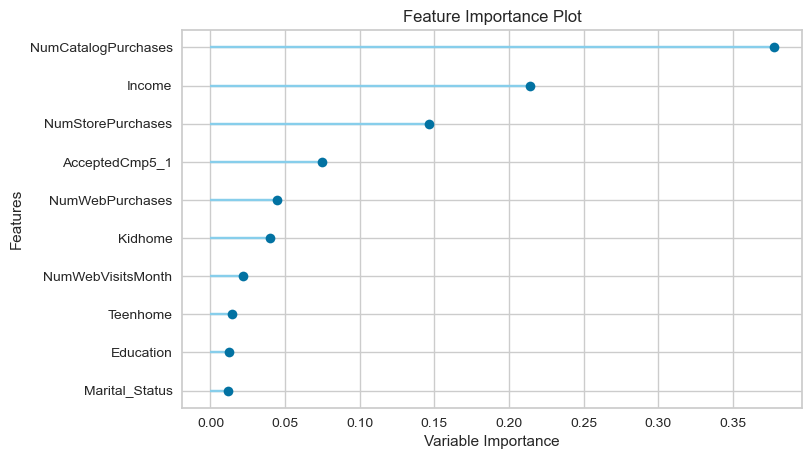

In [39]:
plot_model(model, plot='feature')

In [40]:
tuned = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
Fold,,,,,,,
0,140.2877,52036.4142,228.1149,0.8391,0.3085,0.2704,0.2232
1,113.0969,42655.8914,206.5330,0.8865,0.3265,0.2878,0.1773
2,145.5346,53329.7017,230.9322,0.8437,0.3352,0.3125,0.2296
3,163.8436,68214.1597,261.1784,0.8515,0.5359,0.9237,0.2266
4,135.4104,44309.9001,210.4992,0.8821,0.3170,0.2887,0.2094
5,115.0400,44419.4416,210.7592,0.8929,0.2914,0.2486,0.1909
6,114.1452,52351.2575,228.8040,0.8587,0.2798,0.2236,0.2033
7,122.9603,39869.9060,199.6745,0.8571,0.2535,0.2170,0.1953
8,118.8846,46320.8348,215.2228,0.8670,0.3750,0.3559,0.2133


In [41]:
final = finalize_model(model)
final

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=25, verbose=0, warm_start=False)

In [42]:
predict_model(final)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
0,Extra Trees Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp1_1,AcceptedCmp2_1,AcceptedCmp3_0,AcceptedCmp4_1,AcceptedCmp5_1,Complain_1,Response_1,target,Label
0,2,4,0.236078,0.5,0.0,0.363636,0.200000,0.259259,0.090909,0.230769,0.45,0.0,0.0,1.0,0.0,0.0,0.0,1.0,299,299.0
1,2,3,0.196045,0.5,0.0,0.282828,0.066667,0.074074,0.000000,0.230769,0.35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,71,71.0
2,4,4,0.531895,0.0,0.0,0.737374,0.066667,0.370370,0.181818,0.461538,0.15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1923,1923.0
3,3,4,0.259705,0.0,0.5,0.000000,0.200000,0.185185,0.090909,0.615385,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,393,393.0
4,2,6,0.241867,0.5,0.5,0.303030,0.333333,0.111111,0.363636,0.230769,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258,258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,4,3,0.398122,0.0,0.5,0.505050,0.133333,0.185185,0.363636,0.769231,0.20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,656,656.0
329,3,3,0.221813,0.5,0.0,0.040404,0.066667,0.037037,0.000000,0.153846,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,30.0
330,2,3,0.487928,0.0,0.0,0.474747,0.066667,0.111111,0.636364,0.615385,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1495,1495.0
331,4,2,0.304269,0.0,0.5,0.565657,0.133333,0.148148,0.000000,0.307692,0.35,0.0,0.0,1.0,0.0,0.0,0.0,0.0,149,149.0


In [43]:
pred = predict_model(final, data=test)
pred

,Education,Marital_Status,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Label
0,2,4,0,0,0,0,0,0,0,0.082940,0.5,0.0,0.838384,0.266667,0.16,0.107143,0.615385,0.20,407.32
1,2,5,0,0,0,0,0,1,0,0.095301,0.0,0.5,0.585859,0.133333,0.08,0.142857,0.769231,0.05,372.57
2,2,3,0,0,0,0,0,0,0,0.079773,0.5,0.0,0.212121,0.200000,0.20,0.107143,1.000000,0.20,587.66
3,2,3,0,0,0,1,0,0,0,0.098264,0.0,0.5,0.080808,0.266667,0.28,0.142857,1.000000,0.25,741.73
4,2,5,1,0,0,0,0,0,0,0.125198,0.0,0.5,0.898990,0.133333,0.24,0.250000,0.692308,0.15,642.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,2,3,0,0,0,0,0,0,0,0.050069,0.5,0.5,0.545455,0.200000,0.08,0.000000,0.307692,0.20,64.66
1104,3,5,0,0,0,0,0,0,0,0.050401,0.5,0.5,0.565657,0.066667,0.04,0.000000,0.230769,0.25,28.26
1105,4,4,0,0,0,0,0,0,0,0.047498,0.0,0.0,0.464646,0.066667,0.04,0.035714,0.230769,0.20,52.48
1106,2,5,0,0,0,0,0,0,0,0.109011,0.5,1.0,0.909091,0.466667,0.08,0.178571,0.384615,0.25,259.59


In [44]:
sample_submission['target'] = pred['Label']

In [45]:
sample_submission.to_csv("pycaret_et.csv", index=False)